# To run this, you need to run (or have run) the following in docker:
```
pip install textblob
pip install nltk
pip install twitterscraper
```

In [1]:
from twitterscraper import query_tweets
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import csr_matrix
import seaborn as sns
import hypertools as hyp
import numpy as np
from textblob import TextBlob as tb
import nltk
import datetime as dt
nltk.download('brown')
nltk.download('punkt')
%matplotlib inline

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Exploring twitter data

Scrape twitter for a keyword, fit topic models, do sentiment analyses on the tweets, and make a plot

In [1]:
#scrape twitter for most recent tweets on the election...this will take a while
n_tweets = 500
tweets = []
for tweet in query_tweets("election", n_tweets)[:n_tweets]:
    tweets.append(tweet)

NameError: name 'query_tweets' is not defined

In [3]:
tweets[0].timestamp

datetime.datetime(2017, 10, 10, 18, 29, 55)

In [4]:
#get the tweet text
tweet_text = list(map(lambda x: x.text, tweets))

In [5]:
#convert the data to a useable format
n_features = 1000
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=n_features, stop_words='english')
tf = tf_vectorizer.fit_transform(tweet_text)
tf_feature_names = tf_vectorizer.get_feature_names()

In [6]:
#fit a topic model to the tweets
n_topics = 10
lda = LDA(n_topics=n_topics, max_iter=5, learning_method='online', learning_offset=50., random_state=0).fit(tf)
tweet_topics = lda.fit(tf)

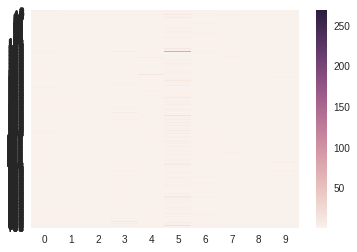

In [7]:
#topic vectors for each tweet
sns.heatmap(tweet_topics.components_.T)

In [8]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print('Topic ' + str(topic_idx) + ': ', end='')
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [9]:
display_topics(lda, tf_feature_names, 10)

Topic 0: election 10 news government russia www https youtube com http
Topic 1: http bit ly election ll snpy élection rolled fraud carpet
Topic 2: election order https ift fair laws register remember raila shut
Topic 3: election odinga kenya raila http withdraws news run opposition com
Topic 4: election fair free credible yes kenyans washingtonpost need kenya decision
Topic 5: election com twitter https http status 2017 day www pic
Topic 6: election people time change com candidates agenda pic twitter http
Topic 7: mins covering 32 stop lies coverage policy prez owe called
Topic 8: bannon corker election gop maybe cycle http political collusion headline
Topic 9: recode election meddlers finds google daily russian traces https goo


In [2]:
sns.heatmap(tf.todense())

NameError: name 'sns' is not defined

In [11]:
blob = tb(tweet_text[0])

In [12]:
def tweet_sentiment(tweet):
    b = tb(tweet)
    return np.sum(np.array(list(map(lambda x: x.sentiment.polarity, b.sentences))))

In [14]:
#happiest tweet
tweet_text[np.where(sentiments == np.max(sentiments))[0][0]]

"Raila's withdrawal is a wise idea. There was no need of participation in election where he feels it won't be fair and verifiable."

In [15]:
#saddest tweet
tweet_text[np.where(sentiments == np.min(sentiments))[0][0]]

'Pathetic.  As in the election, May comes across in this interview as ultra-cautious, slippery, insincere and a typical mainstream politician'

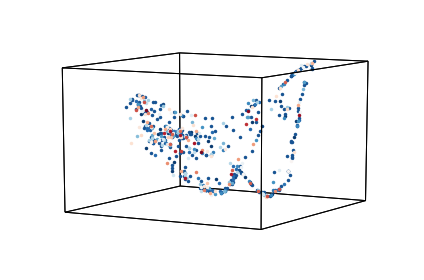

In [16]:
#make a hypertools plot of the tweets, colored by sentiment
hyp.plot(tweet_topics.components_.T, '.', group=sentiments, palette='RdBu_r', model='SpectralEmbedding');

# Defining some useful Twitter-related functions

In [16]:
# function for scraping twitter for one or more keywords and returning a dictionary with:
# - tweets: the tweet text (list of length n_tweets)
# - topicvecs: the tweet topic vectors (numpy array with n_tweets rows and n_topics columns)
# - topwords: the top n words from each topic (list of length n_topics, where each element is a list of n_words)
# - sentiments: the sentiment valence of each tweet (numpy array of length n_tweets)

def twitter_magic(keywords, n_tweets=500, n_topics=10, n_words=5, model=None):
    #if keywords is a list, combine all keywords into a single string, where each word is separated by " OR "
    if type(keywords) == list:
        keywords = ' OR '.join(keywords)
    
    #get the tweets
    tweets = []
    for tweet in query_tweets(keywords, n_tweets)[:n_tweets]:
        tweets.append(tweet)
    
    #get the tweet text
    tweet_text = list(map(lambda x: x.text, tweets))
    
    #fit a topic model to the tweet text    
    n_features = 1000
    tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=n_features, stop_words='english')
    tf = tf_vectorizer.fit_transform(tweet_text)    
    vocab = tf_vectorizer.get_feature_names()
    
    if model == None:
        lda = LDA(n_topics=n_topics, max_iter=5, learning_method='online', learning_offset=50., random_state=0).fit(tf)
    else:
        lda = model            
    tweet_topics = lda.fit(tf)
    
    def get_top_words(model, vocab, n_words):
        top_words = []
        for topic_idx, topic in enumerate(model.components_):       
            next = topic.argsort()[:-n_words - 1:-1]
            top_words.append(list(map(lambda x: vocab[x], next)))
        return top_words
    
    def tweet_sentiment(tweet):
        b = tb(tweet)
        return np.sum(np.array(list(map(lambda x: x.sentiment.polarity, b.sentences))))
    
    return{'tweets': tweet_text,
           'topicvecs': lda.components_.T,
           'topwords': get_top_words(lda, vocab, n_words),
           'sentiments': np.array(list(map(tweet_sentiment, tweet_text))),
           'model': lda}

In [17]:
n = 100 #number of tweets to download for each candidate

trump = twitter_magic(['election AND trump'], n_tweets=n)

#now fit clinton tweets using the topic model from trump_election_tweets (otherwise the topic vectors will be different)
clinton = twitter_magic(['election AND clinton', 'election AND hillary'], n_tweets=n, model=trump['model'])

#now fit sanders tweets (using the same topic model)
sanders = twitter_magic(['election AND sanders', 'election AND bernie'], n_tweets=n, model=trump['model'])

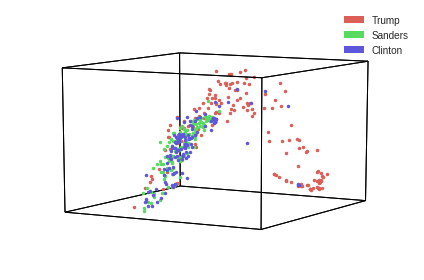

In [18]:
#plot the trump and clinton tweets
hyp.plot([trump['topicvecs'], sanders['topicvecs'], clinton['topicvecs']],
         '.', model='SpectralEmbedding', legend=['Trump', 'Sanders', 'Clinton']);

In [19]:
#get the happiest and saddest tweets from each candidate
def get_happiest_tweets(results):
    return results['tweets'][np.where(results['sentiments'] == np.max(results['sentiments']))[0][0]]

def get_saddest_tweets(results):
    return results['tweets'][np.where(results['sentiments'] == np.min(results['sentiments']))[0][0]]

candidates = ['trump', 'sanders', 'clinton']

print('HAPPIEST TWEETS:')
for c in candidates:
    print(c.upper() + '-CONTAINING: ' + get_happiest_tweets(eval(c)) + '\n')
    
print('\n\nSADDEST TWEETS:')
for c in candidates:
    print(c.upper() + '-CONTAINING: ' + get_saddest_tweets(eval(c)) + '\n')

HAPPIEST TWEETS:
TRUMP-CONTAINING: Lol no. NY usually votes Democrat in the presidential election.
Hilary & the DNC cheated Bernie out of winning. He would've beat Trump.

SANDERS-CONTAINING: Honestly, I didnt like Trump, Bernie or Clinton. Perfect 'pick your poison' election.

CLINTON-CONTAINING: Proof Bush/Gore election was fixed. Re, Gore won popular vote like Hillary. *Important- mash arrow 2 read posted*

https://m.youtube.com/watch?v=AXyl_YNA8Hs …



SADDEST TWEETS:
TRUMP-CONTAINING: The fucked up thing is, Trump believes that his victory in the election validates this approach to politics; that it "works"

SANDERS-CONTAINING: Bernie only appealed to the young Demographics. Every candidate in this election was flawed. Let's hope the idiot in chief is not re-elected

CLINTON-CONTAINING: Robert Muller is wasting our money! Hired all Hillary hack lawyers! Investigational go on for years! Morons thank Russia changed election!

